# Harvest Wisely

This notebook outlines the general workflow for the data within the [Harvest Wisely](https://oceancentral.org/track/harvest-wisely) page of the Ocean Central website.

## Figure 1

This is a raw passthrough of data from RAM Legacy Database, which can be downloaded from [here](https://ourworldindata.org/grapher/biomass-fish-stocks-taxa?tab=table&country=Tuna~Mackerels~Shrimps~Sharks+and+rays~Cod+and+haddock~Perch+and+rockfish).


Data source: RAM Legacy Database; Hilborn,et al. (2020). Effective fisheries management instrumental in improving fish stock status.

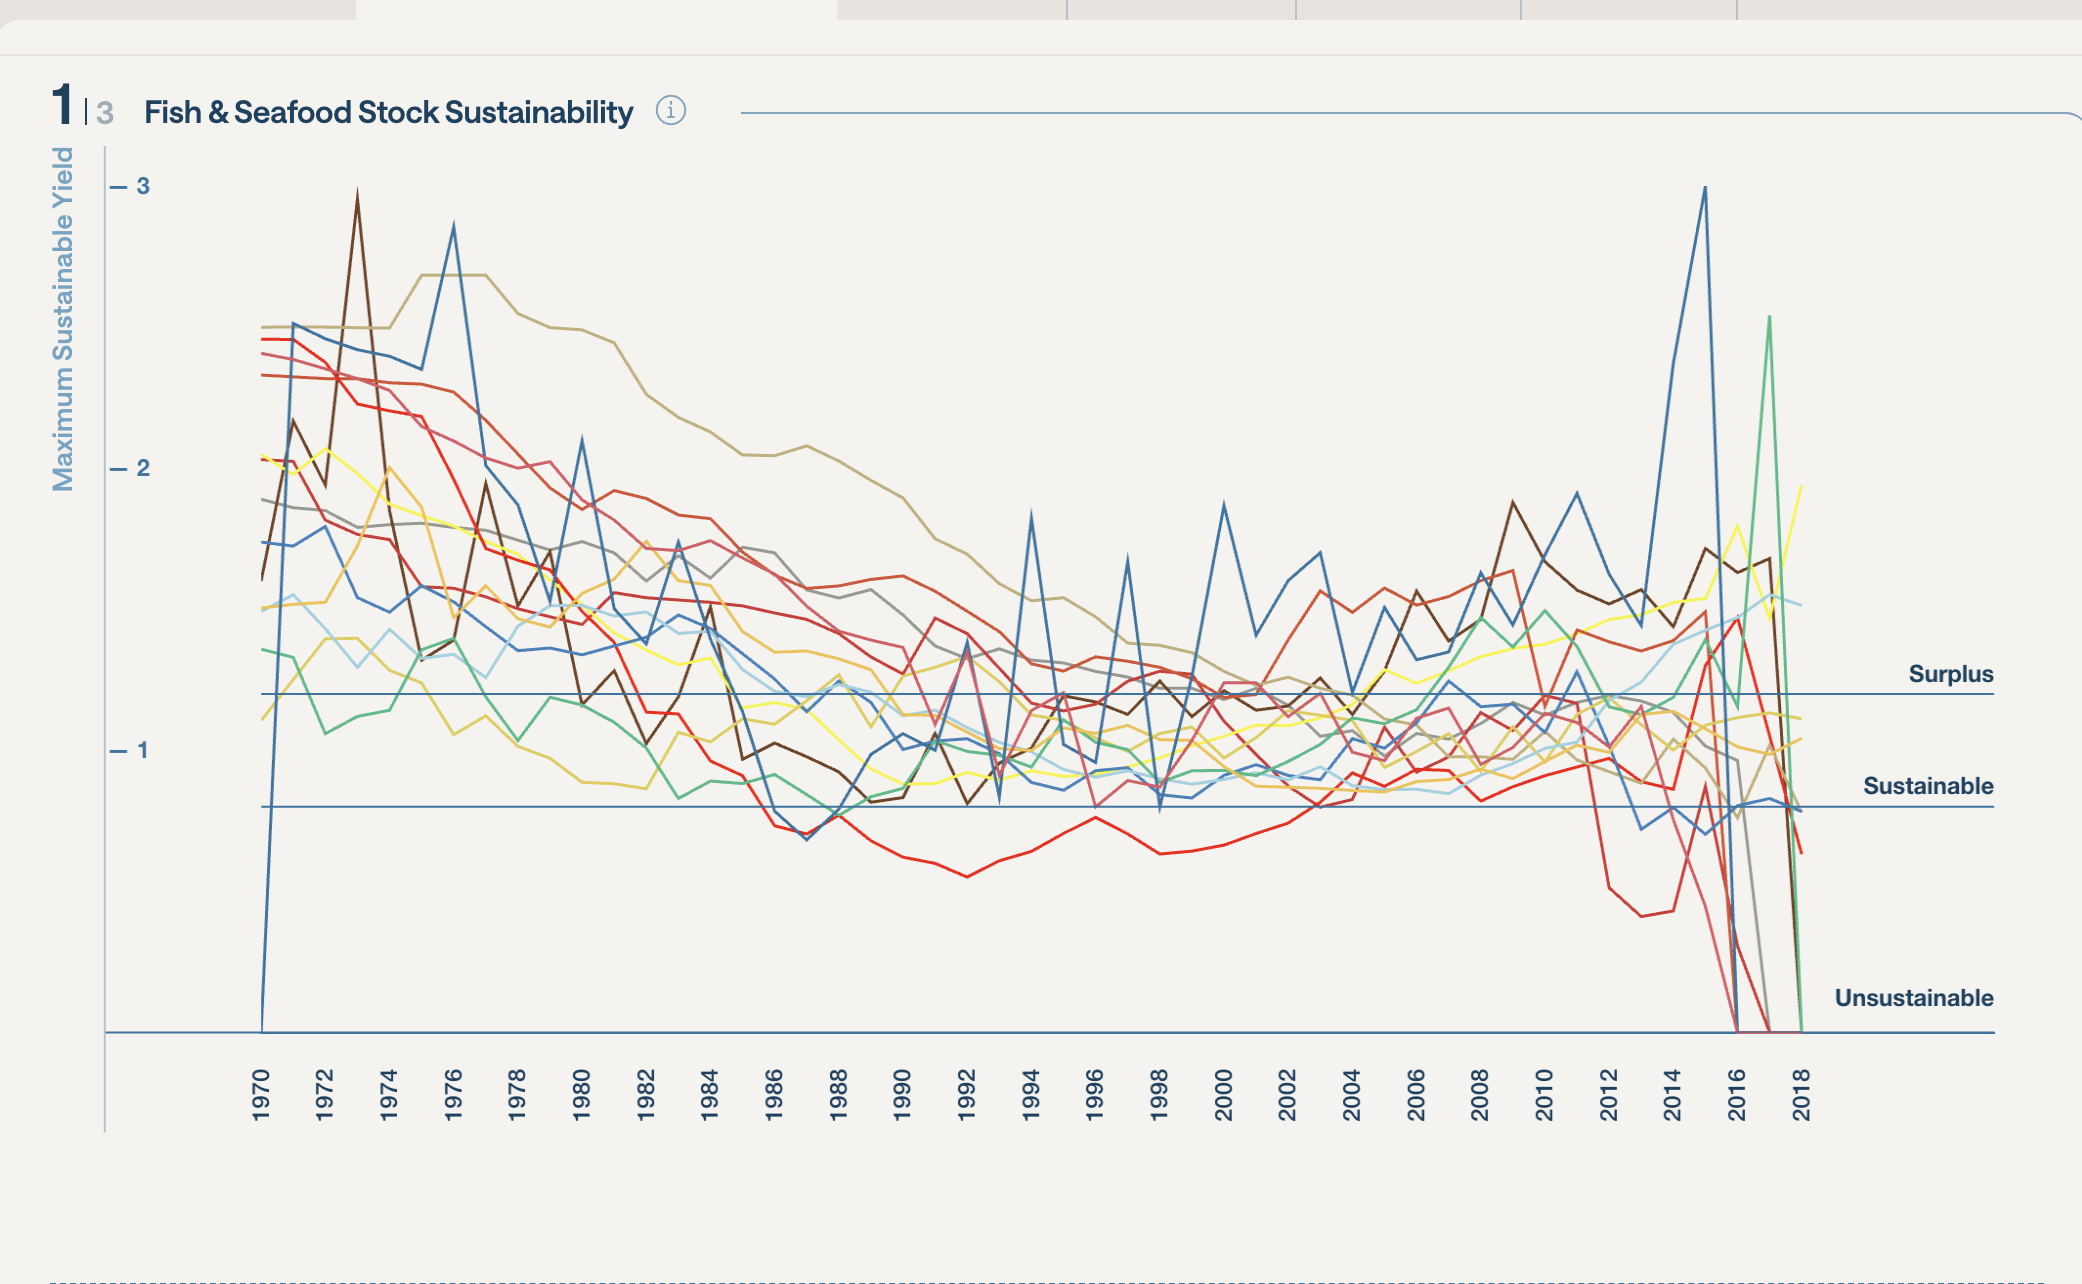

## Figure 2

Coming soon.

## Figure 3

This figure loads in the RAM Legacy Database and maps each stock's most recent measurement of Maximum Sustainable Yield (MSY) to the FAO-defined fishing zones. It then classifies each stock as "surplus", "overfished", or "sustainable" based on its MSY value.

In [ ]:
import pandas as pd
import numpy as np

# Load the RAM Legacy Database timeseries data
df = pd.read_excel("../Data/RAMLDB v4.65 (assessment data only).xlsx", sheet_name="timeseries.1")

# Load the RAM Legacy Database stock data
region_df = pd.read_excel("../Data/RAMLDB v4.65 (assessment data only).xlsx", sheet_name="stock")

# Join the two pandas dataframes together
df = df.merge(region_df[['stockid','region']],on='stockid')

# Filter the data based on the 'tsid' to the Maximum Sustainable Yield variable and non-null 'tsvalue'
df = df.query("tsid == 'BdivBmsypref-dimensionless' & ~tsvalue.isna()")

# Get the newest value of 'tsvalue' for each 'stockid' based on the 'year'
latest_values = df.loc[df.groupby('stockid')['tsyear'].idxmax()]

# Display the result
latest_values

In [ ]:
# Define classification function for surplus, sustainable, and overfished 
def classify_msy(value):
    if value > 0.8:
        return "not_overfished"
    else:
        return "overfished"

# Define the mapping from regions to FAO zone numbers
region_to_fao_zone = {
    'US East Coast': '21',
    'South America': '41, 87',
    'Indian Ocean': '51, 57',
    'Mediterranean-Black Sea': '37',
    'Atlantic Ocean': '21, 27, 31, 34, 41, 47',
    'Pacific Ocean': '67, 71, 77, 81, 87',
    'US Alaska': '67',
    'European Union': '27, 37',
    'Japan': '61',
    'US West Coast': '67, 77',
    'Canada East Coast': '21',
    'Other': np.nan,
    'New Zealand': '81',
    'Australia': '57, 71, 81',
    'US Southeast and Gulf': '31',
    'Canada West Coast': '67',
    'Europe non EU': '27',
    'Southern Africa': '47, 51',
    'US Hawaii': '77'
}

# Apply classification to 'tsvalue'
latest_values['classification'] = latest_values['tsvalue'].apply(classify_msy)

# Apply the mapping to create a new column in the DataFrame
latest_values['FAO_zone'] = latest_values['region'].map(region_to_fao_zone)
latest_values

In [ ]:
# Split rows with multiple FAO zones into separate rows
data_expanded = latest_values.dropna(subset=['FAO_zone']).assign(
    FAO_zone=latest_values['FAO_zone'].str.split(', ')
).explode('FAO_zone')

# Convert FAO_zone to integers
data_expanded['FAO_zone'] = data_expanded['FAO_zone'].astype(int)

# Group by FAO zone and count the number of rows for each classification
grouped_data = data_expanded.groupby('FAO_zone')['classification'].value_counts().unstack(fill_value=0)

# Rename columns for clarity
grouped_data = grouped_data.rename(columns={
    'not_overfished': 'count_not_overfished',
    'overfished': 'count_overfished',
})

grouped_data = grouped_data.reset_index()

# Display the grouped data
grouped_data

In [ ]:
import geopandas as gpd

# Read the FAO zones shapefile
zones_df = gpd.read_file("../Data/fao/World_Fao_Zones.shp")

# Merge the grouped data with the FAO zones GeoDataFrame
final_df = zones_df.merge(grouped_data, left_on='zone', right_on='FAO_zone')

# Ensure the final DataFrame is a GeoDataFrame
final_gdf = gpd.GeoDataFrame(final_df, geometry='geometry')

# FAO_zone to Fishing Zone mapping from your second image
fishing_zone_mapping = {
    18: "Arctic Sea",
    21: "Atlantic, Northwest",
    27: "Atlantic, Northeast",
    31: "Atlantic, Western-central",
    34: "Atlantic, Eastern Central",
    37: "Mediterranean and Black Sea",
    41: "Atlantic, Southwest",
    47: "Atlantic, Southeast",
    48: "Atlantic, Antarctic",
    51: "Indian Ocean, Western",
    57: "Indian Ocean, Eastern",
    58: "Indian Ocean, Antarctic And Southern",
    61: "Pacific, Northwest",
    67: "Pacific, Northeast",
    71: "Pacific, Western Central",
    77: "Pacific, Eastern Central",
    81: "Pacific, Southwest",
    87: "Pacific, Southeast",
    88: "Pacific, Antarctic"
}

# Create a new column by mapping FAO_zone to Fishing Zone
final_gdf['Fishing_Zone'] = final_gdf['FAO_zone'].map(fishing_zone_mapping)

# Save the result as a GeoJSON file
final_gdf[['Fishing_Zone','count_not_overfished','count_overfished','geometry']].to_file("../Data/harvest_wisely_3.geojson", driver='GeoJSON')
final_gdf

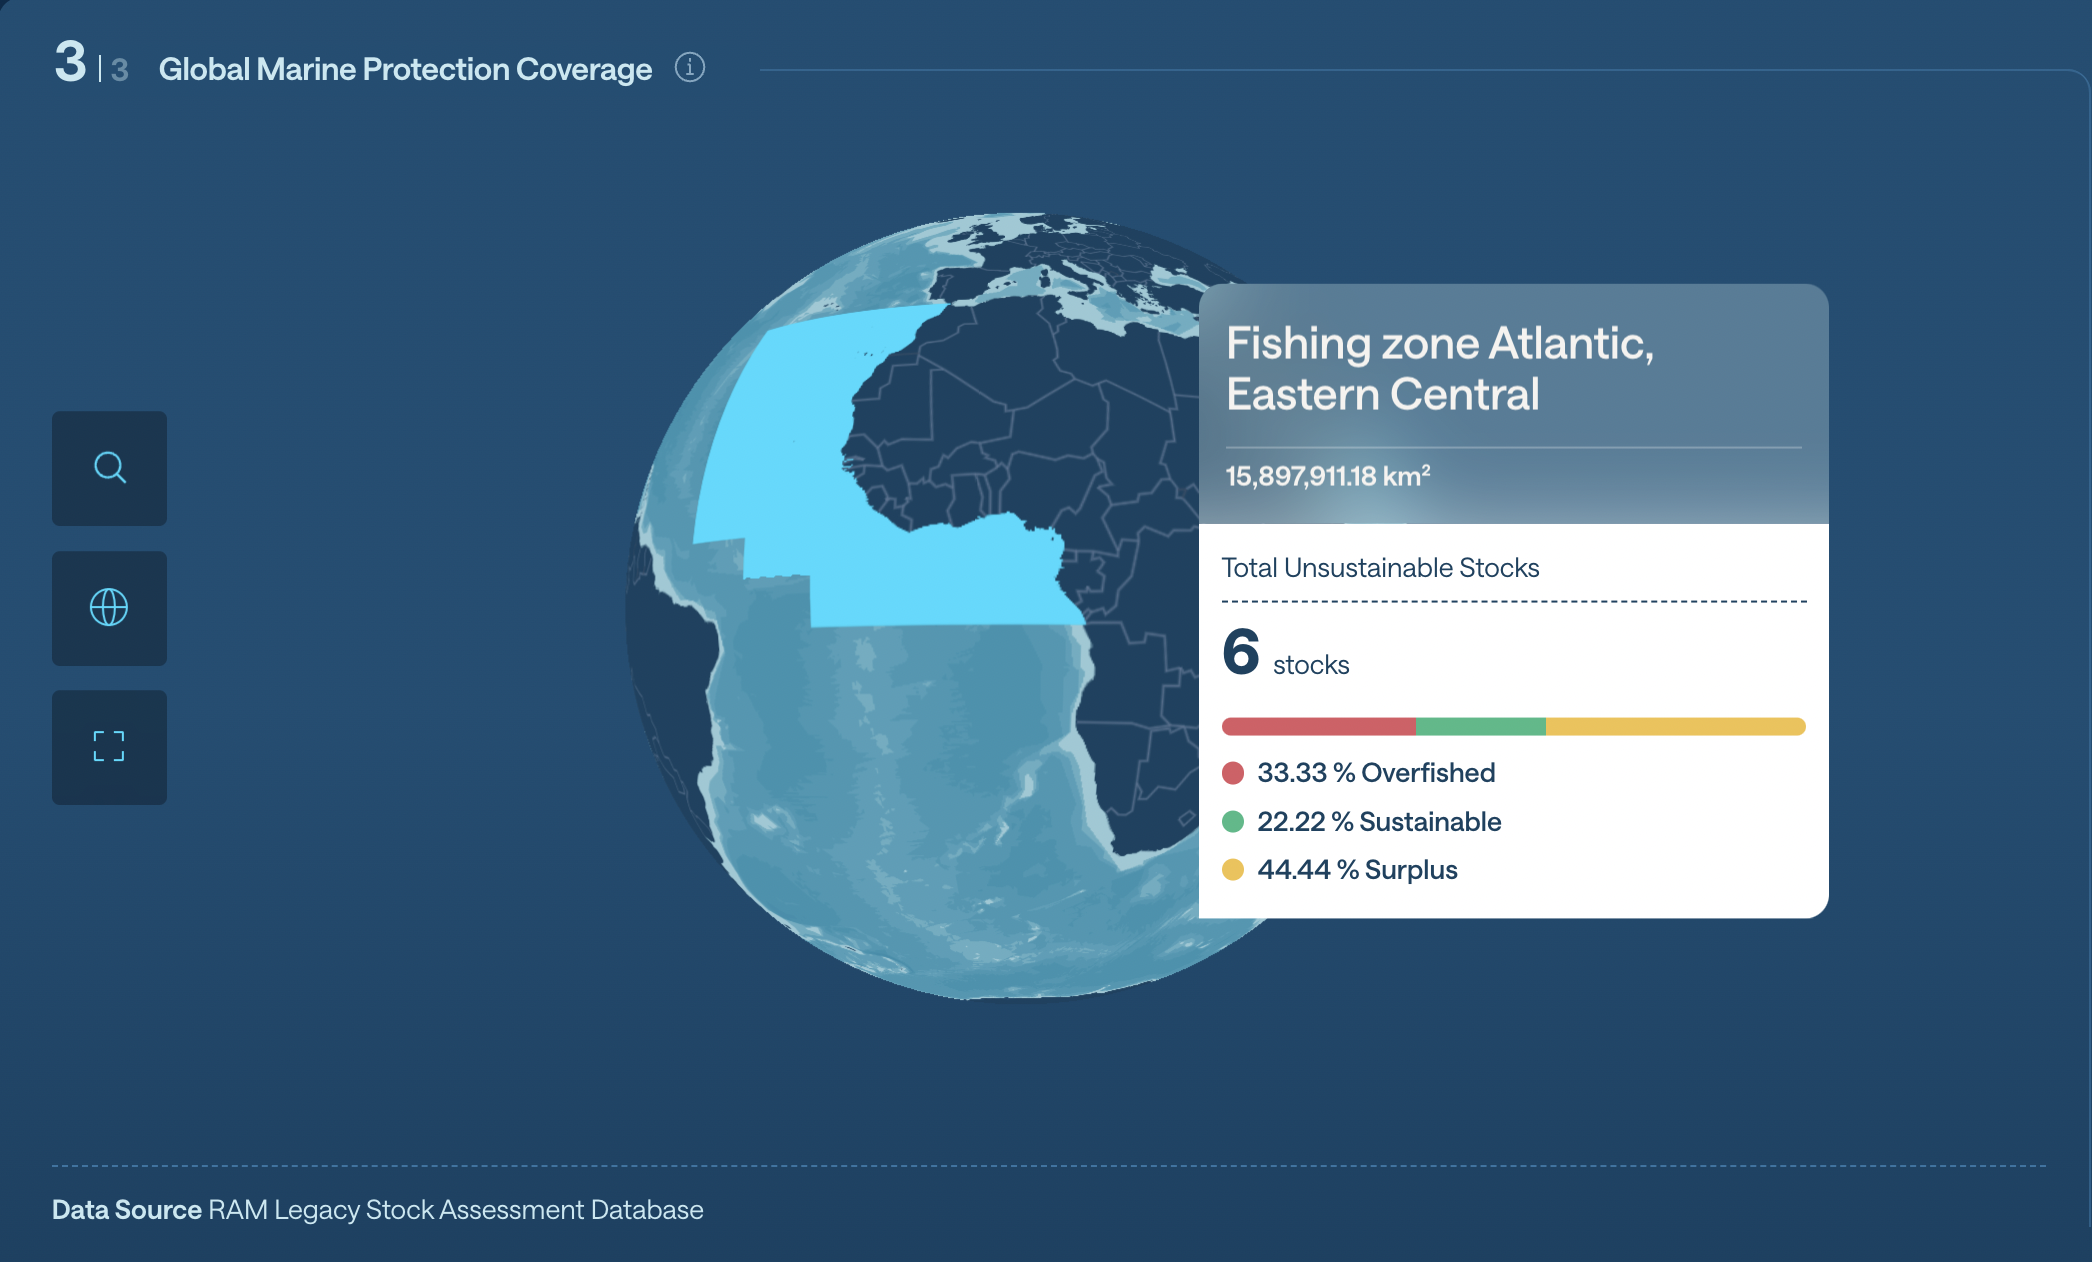